In [1]:
import typing
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt
import functools
from sklearn.decomposition import PCA

import paradime as prdm

In [2]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
num_pts = 5000
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:num_pts][np.argsort(mnist.targets[:num_pts])]
testtargets = np.sort(mnist.targets[:num_pts])

In [4]:
def kullback_leibler_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    kl_matr = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    kl_matr.fill_diagonal_(0.)    
    return torch.sum(kl_matr)

In [5]:
class MyModel(torch.nn.Module):
    def __init__(self,
        in_dim: int,
        out_dim: int,
        hidden_dims: list[int]
    ):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        
        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(torch.nn.Linear(cur_dim, out_dim))

        self.alpha = torch.nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = torch.nn.Softplus()(layer(x))
        out = self.layers[-1](x)
        return out

    def embed(self, x):
        return self.forward(x)

    def classify(self, x):
        return self.forward(x)

In [6]:
mymodel = MyModel(28*28, 2, [100,50])

In [7]:
dr = prdm.ParametricDR(mymodel,
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=prdm.transforms.PerplexityBasedRescale(
            perplexity=100
        )
    ),
    batch_relations=prdm.relations.DifferentiablePDist(
        transform=[
            prdm.transforms.StudentTTransform(alpha=mymodel.alpha),
            prdm.transforms.Normalize(),
            prdm.transforms.Symmetrize(),
            prdm.transforms.ToSquareTensor(),
        ]
    ),
    use_cuda=True,
    verbose=True,
)
dr.set_training_defaults(batch_size=100, n_epochs=40)
dr.add_training_phase(
    name='pca_init',
    loss=prdm.loss.PositionLoss(
        position_key='pca'
    ),
    n_epochs=10
)
dr.add_training_phase(
    name='main',
    loss=prdm.loss.RelationLoss(
        loss_function=kullback_leibler_loss
    )
)
dr.register_dataset({
    'data': testdata,
    'labels': testtargets,
    'pca': torch.tensor(PCA(n_components=2).fit_transform(testdata)),
    }
)
dr.train()

2022-07-19 16:47:47.8: Computing global relations rel.
2022-07-19 16:48:11.7: Beginning training phase main.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [14]:
for i in dr.model.parameters():
    print(i.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [16]:
d = int(np.ceil(np.sqrt(x.shape[0] * 2)))

In [18]:
d * (d-1)

90

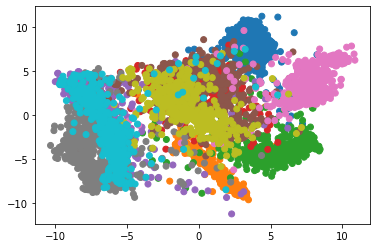

In [21]:
emb = dr.model(testdata).detach()
plt.scatter(
    x=emb[:,0],
    y=emb[:,1],
    c=[ plt.get_cmap('tab10')(t) for t in testtargets ]
)